**1. Mount drive**

In [30]:
from google.colab import drive
drive.mount('/content/drive')

import os

DATA_DIR = "/content/drive/MyDrive/Rahul_DTSC5082_Project/Scenario2_MIMIC/data"
print("Data directory:", DATA_DIR)

# List files to verify everything is there
!ls "$DATA_DIR"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data directory: /content/drive/MyDrive/Rahul_DTSC5082_Project/Scenario2_MIMIC/data
admissions.csv	     edstays.csv	   RA_Multimodal_ClinicalBERT_FINAL.csv
diagnoses_icd.csv    labevents.csv	   services.csv
diagnosis.csv	     patients.csv	   transfers.csv
d_icd_diagnoses.csv  procedures_icd.csv    triage.csv
discharge.csv	     radiology.csv	   vitalsign.csv
d_labitems.csv	     radiology_detail.csv


**2. Load Diagnosis and check which ICD it is?**

In [31]:
# Mount Google Drive and define base directories for raw MIMIC data and outputs
import pandas as pd

diag_path = f"{DATA_DIR}/diagnoses_icd.csv"

use_cols = ["subject_id", "hadm_id", "icd_code", "icd_version"]

# Load with dtype settings to reduce memory usage
dtypes = {
    "subject_id": "int32",
    "hadm_id": "float32",
    "icd_code": "string",
    "icd_version": "int8"
}

diagnoses = pd.read_csv(diag_path, dtype=dtypes)

print("Shape:", diagnoses.shape)
diagnoses.head()


Shape: (6364488, 5)


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595852.0,1,5723,9
1,10000032,22595852.0,2,78959,9
2,10000032,22595852.0,3,5715,9
3,10000032,22595852.0,4,07070,9
4,10000032,22595852.0,5,496,9


**3. Extract RA Diagnoses (ICD-9 + ICD-10)**

In [32]:
# Normalize ICD codes: as string, uppercase, remove dots
diagnoses["icd_code_norm"] = (
    diagnoses["icd_code"]
    .astype(str)
    .str.upper()
    .str.replace(".", "", regex=False)
)

# RA in ICD-10: M05*, M06*
mask_icd10 = (
    (diagnoses["icd_version"] == 10)
    & (
        diagnoses["icd_code_norm"].str.startswith("M05")
        | diagnoses["icd_code_norm"].str.startswith("M06")
    )
)

# RA in ICD-9: 714*  (Rheumatoid arthritis)
mask_icd9 = (
    (diagnoses["icd_version"] == 9)
    & diagnoses["icd_code_norm"].str.startswith("714")
)

# Combine both
mask_ra = mask_icd9 | mask_icd10

RA_diag = diagnoses[mask_ra].copy()

print("RA_diag shape:", RA_diag.shape)
print("Unique RA patients:", RA_diag["subject_id"].nunique())
print("Unique RA admissions:", RA_diag["hadm_id"].nunique())

RA_diag.head()


RA_diag shape: (8611, 6)
Unique RA patients: 3653
Unique RA admissions: 8531


,subject_id,hadm_id,seq_num,icd_code,icd_version,icd_code_norm
1913,10002443,21329020.0,8,M069,10,M069
2605,10003203,25146996.0,7,7140,9,7140
7204,10010718,29947356.0,7,M06042,10,M06042
7205,10010718,29947356.0,8,M06041,10,M06041
7313,10010997,20783870.0,8,M069,10,M069


In [33]:
# Recreate RA patients list from RA_diag dataframe

# If RA_diag already exists, extract unique subject IDs
ra_patients = RA_diag['subject_id'].unique().tolist()

print("Number of unique RA patients:", len(ra_patients))


Number of unique RA patients: 3653


**4. Vital information of RA patients**

In [34]:
# ---- STEP 4: Extract vitalsigns for RA patients ----

# Load vitalsign CSV
vitals = pd.read_csv(f"{DATA_DIR}/vitalsign.csv")

print("Vitals shape:", vitals.shape)

# Filter only RA patients
vitals_ra = vitals[vitals['subject_id'].isin(ra_patients)]
print("Filtered RA vitals shape:", vitals_ra.shape)

# Show sample
vitals_ra.head()


Vitals shape: (1564610, 11)
Filtered RA vitals shape: (40573, 11)


,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain
457,10002443,33425241,2183-10-17 22:11:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,uta
458,10002443,33425241,2183-10-17 22:22:00,NaN,92.0,28.0,96.0,116.0,85.0,NaN,NaN
459,10002443,33425241,2183-10-17 23:17:00,98.2,91.0,28.0,96.0,146.0,78.0,NaN,2
460,10002443,33425241,2183-10-17 23:30:00,98.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
687,10003203,34201656,2153-04-26 02:10:00,97.4,81.0,16.0,97.0,157.0,69.0,NaN,NaN


**5. Hospital admission details ,and clinical services**

Here, we will discover how they were came in (Emergency/Elective/Urgent), came from (Home/Clinic/Transfer from another hospital) and where they were discharge (Home/Rehab/Skilled nursing), and also which service treated them (RHEUMATOLOGY/MEDICINE / GENERAL MEDICINE/ORTHOPEDICS/CARDIOLOGY/SURGERY).

This will help with ground truth label for training model.

In [35]:
# ---- STEP 5: Link RA diagnoses to admissions + services (specialty) ----

# Load admissions
admissions = pd.read_csv(
    f"{DATA_DIR}/admissions.csv",
    dtype={
        "subject_id": "int32",
        "hadm_id": "int32",
        "admission_type": "category",
        "admission_location": "category",
        "discharge_location": "category"
    }
)

# Load services (hospital service / specialty)
services = pd.read_csv(
    f"{DATA_DIR}/services.csv",
    dtype={
        "subject_id": "int32",
        "hadm_id": "int32",
        "curr_service": "category"
    }
)

print("admissions:", admissions.shape)
print("services:", services.shape)

# Keep only RA-related admissions
RA_adm = RA_diag.merge(admissions, on=["subject_id", "hadm_id"], how="left")

# Add service / specialty info
RA_with_service = RA_adm.merge(services, on=["subject_id", "hadm_id"], how="left")

print("RA_with_service:", RA_with_service.shape)
RA_with_service[["subject_id", "hadm_id", "icd_code", "admission_type", "admission_location", "curr_service"]].head()


admissions: (546028, 16)
services: (593071, 5)
RA_with_service: (9090, 23)


,subject_id,hadm_id,icd_code,admission_type,admission_location,curr_service
0,10002443,21329020.0,M069,NaN,NaN,NaN
1,10003203,25146996.0,7140,NaN,NaN,NaN
2,10010718,29947356.0,M06042,NaN,NaN,NaN
3,10010718,29947356.0,M06041,NaN,NaN,NaN
4,10010997,20783870.0,M069,OBSERVATION ADMIT,TRANSFER FROM HOSPITAL,MED


**6A: Load ED / triage tables**

In [36]:
import pandas as pd

# ---- STEP 6A: Load ED / triage tables ----

edstays = pd.read_csv(
    f"{DATA_DIR}/edstays.csv",
    dtype={"subject_id": "int32", "hadm_id": "float32", "stay_id": "int32"}
)

triage = pd.read_csv(
    f"{DATA_DIR}/triage.csv",
    dtype={"subject_id": "int32", "stay_id": "int32"}
)

ed_diag = pd.read_csv(
    f"{DATA_DIR}/diagnosis.csv",
    dtype={"subject_id": "int32", "stay_id": "int32"}
)

# We already loaded vitalsign as `vitals` earlier, so we just confirm shape
print("edstays:", edstays.shape)
print("triage:", triage.shape)
print("ed_diag:", ed_diag.shape)
print("vitals (ED vitalsign):", vitals.shape)

triage.head()


edstays: (425087, 9)
triage: (425087, 11)
ed_diag: (899050, 6)
vitals (ED vitalsign): (1564610, 11)


,subject_id,stay_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,10000032,32952584,97.8,87.0,14.0,97.0,71.0,43.0,7,2.0,Hypotension
1,10000032,33258284,98.4,70.0,16.0,97.0,106.0,63.0,0,3.0,"Abd pain, Abdominal distention"
2,10000032,35968195,99.4,105.0,18.0,96.0,106.0,57.0,10,3.0,"n/v/d, Abd pain"
3,10000032,38112554,98.9,88.0,18.0,97.0,116.0,88.0,10,3.0,Abdominal distention
4,10000032,39399961,98.7,77.0,16.0,98.0,96.0,50.0,13,2.0,"Abdominal distention, Abd pain, LETHAGIC"


**6-B. Find RA-related lab tests in d_labitems**

L1- Load all the possible lab tests

In [37]:
import pandas as pd

# ---- LABS L1: Load lab dictionary only (small, safe) ----
d_labitems = pd.read_csv(f"{DATA_DIR}/d_labitems.csv")

print("d_labitems:", d_labitems.shape)
d_labitems.head()


d_labitems: (1650, 4)


,itemid,label,fluid,category
0,50801,Alveolar-arterial Gradient,Blood,Blood Gas
1,50802,Base Excess,Blood,Blood Gas
2,50803,"Calculated Bicarbonate, Whole Blood",Blood,Blood Gas
3,50804,Calculated Total CO2,Blood,Blood Gas
4,50805,Carboxyhemoglobin,Blood,Blood Gas


L2-searched the lab dictionary for tests related to inflammation & autoimmune activity, such as:

C-Reactive Protein (CRP)

Sedimentation Rate (ESR)

White Blood Count (WBC)

Hemoglobin / Hematocrit

Platelets

We matched them by their names in the label field.

In [38]:
# ---- LABS L2: Find RA-related lab tests in d_labitems ----

# Make sure "label" exists; adjust if your column name is slightly different
d_labitems["label_upper"] = d_labitems["label"].str.upper()

patterns = [
    "C-REACTIVE PROTEIN",  # CRP
    " CRP",
    "SED RATE",
    "ERYTHROCYTE SEDIMENTATION",
    " ESR",
    "WHITE BLOOD",         # WBC
    " WBC",
    "HEMOGLOBIN",
    " HGB",
    "HEMATOCRIT",
    " HCT",
    "PLATELET",
    " PLT"
]

mask = d_labitems["label_upper"].str.contains("|".join(patterns), na=False)

ra_lab_items = d_labitems[mask]

print("Number of candidate RA-related lab items:", ra_lab_items.shape[0])
ra_lab_items[["itemid", "label", "category", "fluid"]].head(30)


Number of candidate RA-related lab items: 51


,itemid,label,category,fluid
4,50805,Carboxyhemoglobin,Blood Gas,Blood
8,50810,"Hematocrit, Calculated",Blood Gas,Blood
9,50811,Hemoglobin,Blood Gas,Blood
12,50814,Methemoglobin,Blood Gas,Blood
50,50852,% Hemoglobin A1c,Chemistry,Blood
53,50855,Absolute Hemoglobin,Chemistry,Blood
87,50889,C-Reactive Protein,Chemistry,Blood
303,51115,"Hematocrit, Ascites",Hematology,Ascites
397,51212,Fetal Hemoglobin,Hematology,Blood
406,51221,Hematocrit,Hematology,Blood


L3-Instead of loading the entire HUGE labevents table (which crashed RAM), we:

Read labevents.csv in small chunks (250k rows at a time)

In each chunk, kept only rows where:

The patient has RA

The lab test is one of our RA-relevant itemids

The lab result is numeric

Combined all matching rows into a single dataset:
RA_labs (538,337 rows)

In [39]:
# ---- LABS L3: Extract RA-related lab results in chunks ----

import pandas as pd

# 1) Make sure we have the RA patient list
# (ra_patients should already exist; if not, recreate from RA_diag)
# ra_patients = RA_diag['subject_id'].unique().tolist()

ra_subjects_set = set(ra_patients)

# 2) Lab itemids we care about (CRP, ESR, WBC, Hgb, Platelets, etc.)
ra_lab_item_ids = ra_lab_items["itemid"].unique().tolist()
print("Number of RA-related lab itemids:", len(ra_lab_item_ids))

# 3) Stream labevents in chunks and filter
chunks = []
chunk_size = 250_000  # adjust smaller if RAM still an issue

for i, chunk in enumerate(pd.read_csv(
    f"{DATA_DIR}/labevents.csv",
    usecols=["subject_id", "hadm_id", "itemid", "charttime", "valuenum", "valueuom"],
    dtype={"subject_id": "int32", "itemid": "int32", "hadm_id": "float32"},
    low_memory=False,
    chunksize=chunk_size
)):
    # Filter to RA patients + our lab itemids + non-null values
    mask = (
        chunk["subject_id"].isin(ra_subjects_set)
        & chunk["itemid"].isin(ra_lab_item_ids)
        & chunk["valuenum"].notna()
    )
    filtered = chunk[mask]

    if not filtered.empty:
        chunks.append(filtered)

    if i % 10 == 0:
        print(f"Processed chunk {i}, kept {filtered.shape[0]} rows so far...")

# 4) Combine all filtered chunks
if chunks:
    RA_labs = pd.concat(chunks, ignore_index=True)
else:
    RA_labs = pd.DataFrame(columns=["subject_id", "hadm_id", "itemid", "charttime", "valuenum", "valueuom"])

print("\nFinal RA_labs shape:", RA_labs.shape)
RA_labs.head()


Number of RA-related lab itemids: 51
Processed chunk 0, kept 96 rows so far...
Processed chunk 10, kept 523 rows so far...
Processed chunk 20, kept 775 rows so far...
Processed chunk 30, kept 970 rows so far...
Processed chunk 40, kept 1933 rows so far...
Processed chunk 50, kept 1197 rows so far...
Processed chunk 60, kept 1298 rows so far...
Processed chunk 70, kept 479 rows so far...
Processed chunk 80, kept 728 rows so far...
Processed chunk 90, kept 640 rows so far...
Processed chunk 100, kept 469 rows so far...
Processed chunk 110, kept 3259 rows so far...
Processed chunk 120, kept 291 rows so far...
Processed chunk 130, kept 421 rows so far...
Processed chunk 140, kept 1427 rows so far...
Processed chunk 150, kept 367 rows so far...
Processed chunk 160, kept 376 rows so far...
Processed chunk 170, kept 306 rows so far...
Processed chunk 180, kept 1848 rows so far...
Processed chunk 190, kept 82 rows so far...
Processed chunk 200, kept 1682 rows so far...
Processed chunk 210, kep

,subject_id,hadm_id,itemid,charttime,valuenum,valueuom
0,10002443,NaN,50889,2183-01-26 11:55:00,8.2,mg/L
1,10002443,NaN,51221,2183-01-26 11:55:00,45.3,%
2,10002443,NaN,51222,2183-01-26 11:55:00,14.8,g/dL
3,10002443,NaN,51265,2183-01-26 11:55:00,291.0,K/uL
4,10002443,NaN,51301,2183-01-26 11:55:00,8.3,K/uL


**7. Combine Labs + Vitals + Admissions + Services into a unified RA cohort dataset**

7A- Load Admissions + Filter to RA Patients

In [40]:
# ---- STEP 7A: Load Admissions and filter to RA patients ----

admissions = pd.read_csv(
    f"{DATA_DIR}/admissions.csv",
    dtype={"subject_id": "int32", "hadm_id": "float32"}
)

# Keep only RA patients
adm_ra = admissions[admissions["subject_id"].isin(ra_patients)]

print("Admissions shape:", admissions.shape)
print("Filtered RA admissions shape:", adm_ra.shape)

adm_ra.head()


Admissions shape: (546028, 16)
Filtered RA admissions shape: (14769, 16)


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
150,10002443,21329020.0,2183-10-17 23:20:00,2183-10-20 18:47:00,NaN,EW EMER.,P343TV,TRANSFER FROM HOSPITAL,HOME,Private,English,SINGLE,WHITE,2183-10-17 22:11:00,2183-10-18 00:47:00,0
213,10003203,25146996.0,2153-04-26 02:05:00,2153-04-29 14:19:00,NaN,EU OBSERVATION,P57BOT,EMERGENCY ROOM,NaN,Medicare,English,SINGLE,WHITE,2153-04-25 23:36:00,2153-04-26 03:02:00,0
613,10010718,29947356.0,2169-01-20 13:21:00,2169-01-27 14:20:00,NaN,OBSERVATION ADMIT,P50GUR,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,Modern Greek (1453-),WIDOWED,WHITE,2169-01-20 10:17:00,2169-01-20 14:21:00,0
621,10010997,20783870.0,2139-04-28 16:45:00,2139-05-02 12:20:00,NaN,OBSERVATION ADMIT,P756E2,TRANSFER FROM HOSPITAL,HOME,Private,English,MARRIED,WHITE - OTHER EUROPEAN,2139-04-28 12:54:00,2139-04-29 11:50:00,0
870,10014869,28291416.0,2164-06-25 18:57:00,2164-06-27 17:10:00,NaN,OBSERVATION ADMIT,P62DP0,PHYSICIAN REFERRAL,HOME,Medicare,English,MARRIED,WHITE,2164-06-25 14:33:00,2164-06-26 13:56:00,0


**Some EDA on our Dataset**

1 — RA Patient Summary

In [41]:
# ---- EDA Step 1: RA Cohort Summary ----

import pandas as pd

summary = {
    "Total RA patients": len(ra_patients),
    "Total RA admissions": len(adm_ra),
    "Total RA vital measurements": len(vitals_ra),
    "Total RA lab measurements": len(RA_labs)
}

summary_df = pd.DataFrame(summary.items(), columns=["Metric", "Value"])
summary_df


,Metric,Value
0,Total RA patients,3653
1,Total RA admissions,14769
2,Total RA vital measurements,40573
3,Total RA lab measurements,538337


In [42]:
# ---- EDA Step 2B (Updated): Race frequency table ----

race_table = (
    adm_ra["race"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "Race", "race": "Count"})
)

race_table


,Count,count
0,WHITE,9032
1,BLACK/AFRICAN AMERICAN,2932
2,WHITE - OTHER EUROPEAN,420
3,HISPANIC/LATINO - PUERTO RICAN,409
4,OTHER,390
5,UNKNOWN,206
6,WHITE - RUSSIAN,197
7,ASIAN - CHINESE,162
8,HISPANIC OR LATINO,145
9,BLACK/CAPE VERDEAN,137


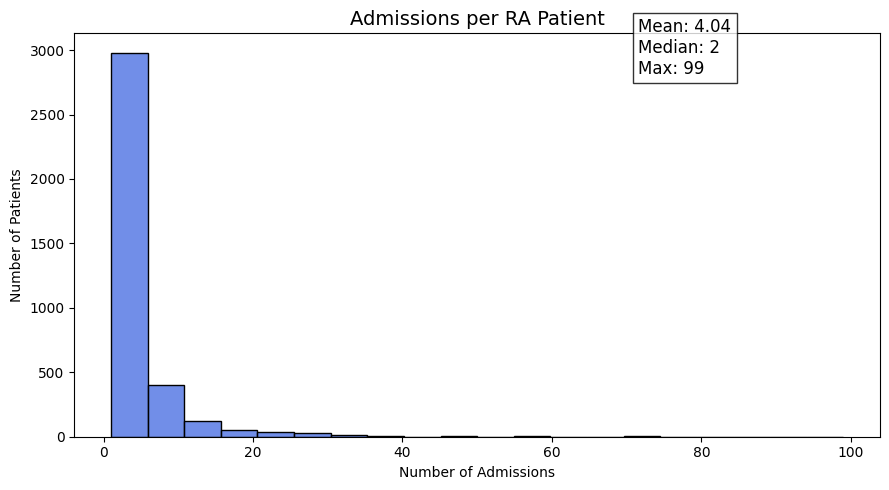

,subject_id,num_admissions
count,3.653000e+03,3653.000000
mean,1.503520e+07,4.042978
std,2.885067e+06,6.116930
min,1.000244e+07,1.000000
25%,1.251634e+07,1.000000
50%,1.507786e+07,2.000000
75%,1.763975e+07,4.000000
max,1.999667e+07,99.000000


In [43]:
# ---- EDA M1: Admissions per RA patient ----

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

adm_count = (
    adm_ra.groupby("subject_id")["hadm_id"]
    .nunique()
    .reset_index()
    .rename(columns={"hadm_id": "num_admissions"})
)

mean_val = adm_count["num_admissions"].mean()
median_val = adm_count["num_admissions"].median()
max_val = adm_count["num_admissions"].max()

plt.figure(figsize=(9,5))
sns.histplot(adm_count["num_admissions"], kde=False, bins=20, color="royalblue")

plt.title("Admissions per RA Patient", fontsize=14)
plt.xlabel("Number of Admissions")
plt.ylabel("Number of Patients")

# Annotate key statistics directly on plot
plt.text(
    0.70, 0.90,
    f"Mean: {mean_val:.2f}\nMedian: {median_val:.0f}\nMax: {max_val}",
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.8)
)

plt.tight_layout()
plt.show()

adm_count.describe()


Most RA cases has small number of admission, with right-skewed because of high-utilization patients. The median is 2 admissions, while the small subsets shows repeated, frequent hospitalizations.

/tmp/ipython-input-2205298266.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


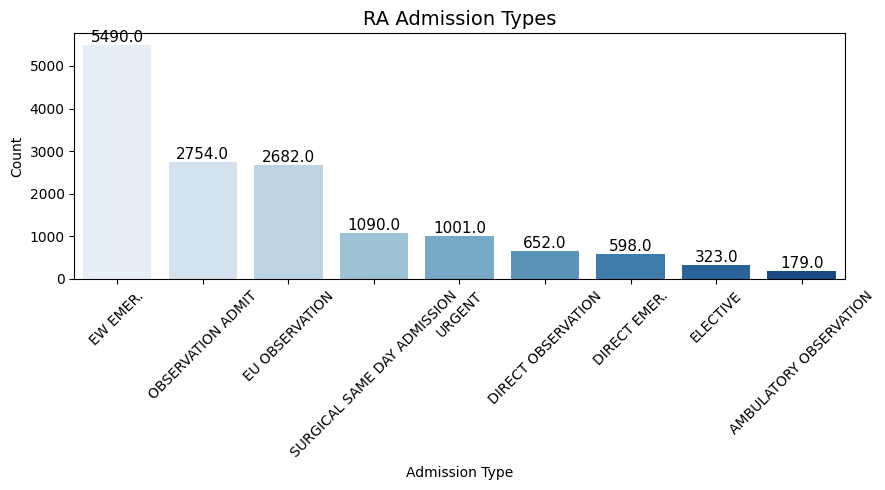

,count
admission_type,
EW EMER.,5490
OBSERVATION ADMIT,2754
EU OBSERVATION,2682
SURGICAL SAME DAY ADMISSION,1090
URGENT,1001
DIRECT OBSERVATION,652
DIRECT EMER.,598
ELECTIVE,323
AMBULATORY OBSERVATION,179


In [44]:
# ---- Meaningful EDA M2 (Improved): Admission type with counts ----

plt.figure(figsize=(9,5))
ax = sns.countplot(
    data=adm_ra,
    x="admission_type",
    order=adm_ra["admission_type"].value_counts().index,
    palette="Blues"
)

plt.title("RA Admission Types", fontsize=14)
plt.xlabel("Admission Type")
plt.ylabel("Count")

# Add numbers on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height}",
        (p.get_x() + p.get_width() / 2., height),
        ha='center', va='bottom', fontsize=11, color='black'
    )

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

adm_ra["admission_type"].value_counts()


Emergency and observation pathways make up most RA admissions, indicating that many patients present with acute or urgent issues rather than planned care.

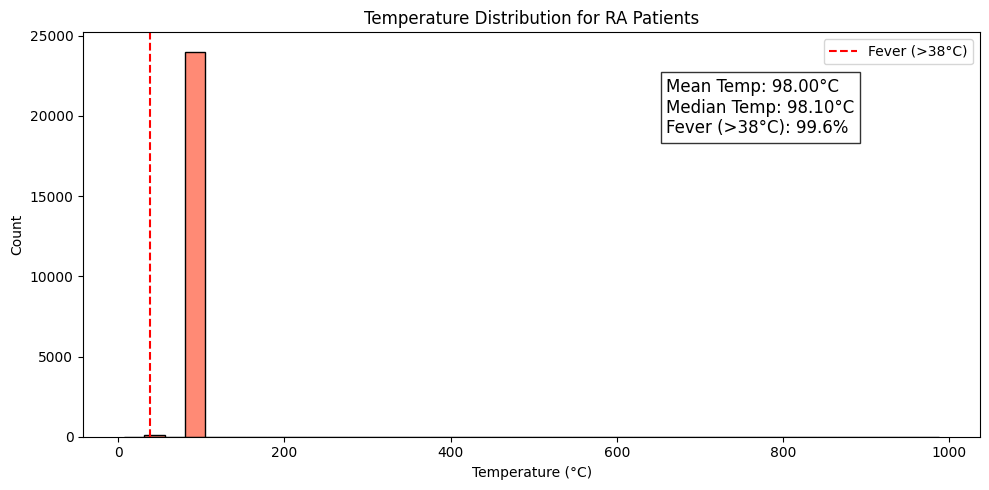

In [45]:
# ---- FINAL Vital EDA: Temperature distribution for RA patients ----

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

temp_vals = vitals_ra["temperature"].dropna()

mean_temp = temp_vals.mean()
median_temp = temp_vals.median()
pct_fever = (temp_vals > 38).mean() * 100   # Fever threshold in °C

plt.figure(figsize=(10,5))
sns.histplot(temp_vals, bins=40, color="tomato")

# Fever threshold line
plt.axvline(38, color="red", linestyle="--", label="Fever (>38°C)")

# Stats box
plt.text(
    0.65, 0.75,
    f"Mean Temp: {mean_temp:.2f}°C\nMedian Temp: {median_temp:.2f}°C\n"
    f"Fever (>38°C): {pct_fever:.1f}%",
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.8)
)

plt.title("Temperature Distribution for RA Patients")
plt.xlabel("Temperature (°C)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


Most recorded temperatures cluster around normal values, with very few measurements exceeding the fever threshold, suggesting fever is uncommon in the RA cohort.

**8. RA_COHORT_MASTER: A full machine-learning-ready dataset**

1 — Initialize RA_COHORT_FINAL

In [46]:
# ---- STEP 1: Initialize RA_COHORT_FINAL with RA admissions ----

# Make a copy so we keep adm_ra untouched
RA_COHORT_FINAL = adm_ra.copy()

print("Initial RA_COHORT_FINAL shape:", RA_COHORT_FINAL.shape)
RA_COHORT_FINAL.head()


Initial RA_COHORT_FINAL shape: (14769, 16)


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
150,10002443,21329020.0,2183-10-17 23:20:00,2183-10-20 18:47:00,NaN,EW EMER.,P343TV,TRANSFER FROM HOSPITAL,HOME,Private,English,SINGLE,WHITE,2183-10-17 22:11:00,2183-10-18 00:47:00,0
213,10003203,25146996.0,2153-04-26 02:05:00,2153-04-29 14:19:00,NaN,EU OBSERVATION,P57BOT,EMERGENCY ROOM,NaN,Medicare,English,SINGLE,WHITE,2153-04-25 23:36:00,2153-04-26 03:02:00,0
613,10010718,29947356.0,2169-01-20 13:21:00,2169-01-27 14:20:00,NaN,OBSERVATION ADMIT,P50GUR,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,Modern Greek (1453-),WIDOWED,WHITE,2169-01-20 10:17:00,2169-01-20 14:21:00,0
621,10010997,20783870.0,2139-04-28 16:45:00,2139-05-02 12:20:00,NaN,OBSERVATION ADMIT,P756E2,TRANSFER FROM HOSPITAL,HOME,Private,English,MARRIED,WHITE - OTHER EUROPEAN,2139-04-28 12:54:00,2139-04-29 11:50:00,0
870,10014869,28291416.0,2164-06-25 18:57:00,2164-06-27 17:10:00,NaN,OBSERVATION ADMIT,P62DP0,PHYSICIAN REFERRAL,HOME,Medicare,English,MARRIED,WHITE,2164-06-25 14:33:00,2164-06-26 13:56:00,0


2 — Merge Service/Specialty

In [47]:
# ---- STEP 2: Merge clinical service into RA_COHORT_FINAL ----

RA_COHORT_FINAL = RA_COHORT_FINAL.merge(
    services[["subject_id", "hadm_id", "curr_service"]],
    on=["subject_id", "hadm_id"],
    how="left"
)

print("After adding service:", RA_COHORT_FINAL.shape)
RA_COHORT_FINAL[["subject_id", "hadm_id", "admission_type", "curr_service"]].head()


After adding service: (15462, 17)


,subject_id,hadm_id,admission_type,curr_service
0,10002443,21329020.0,EW EMER.,NaN
1,10003203,25146996.0,EU OBSERVATION,NaN
2,10010718,29947356.0,OBSERVATION ADMIT,NaN
3,10010997,20783870.0,OBSERVATION ADMIT,MED
4,10010997,20783870.0,OBSERVATION ADMIT,ORTHO


3 — Create Vitals Summary Table using hadm_id

In [48]:
# ---- STEP 3 (clean version): Aggregate vitals per admission ----

# 0) Rebuild RA vitals fresh from original 'vitals' table
vitals_ra = vitals[vitals["subject_id"].isin(ra_patients)].copy()

print("Fresh vitals_ra shape:", vitals_ra.shape)
print("vitals_ra columns:", vitals_ra.columns.tolist())

# 1) Attach hadm_id to each ED stay using edstays (stay_id -> hadm_id)
vitals_ra_with_hadm = vitals_ra.merge(
    edstays[["stay_id", "hadm_id"]],
    on="stay_id",
    how="left"
)

# Keep only rows that belong to a hospital admission
vitals_ra_with_hadm = vitals_ra_with_hadm.dropna(subset=["hadm_id"])
vitals_ra_with_hadm["hadm_id"] = vitals_ra_with_hadm["hadm_id"].astype("int64")

print("RA vitals with hadm_id shape:", vitals_ra_with_hadm.shape)

# 2) Ensure vitals columns are numeric (convert strings like 'UTA' to NaN)
num_cols = ["temperature", "heartrate", "resprate", "o2sat", "sbp", "dbp", "pain"]
for c in num_cols:
    if c in vitals_ra_with_hadm.columns:
        vitals_ra_with_hadm[c] = pd.to_numeric(vitals_ra_with_hadm[c], errors="coerce")

print(vitals_ra_with_hadm[num_cols].dtypes)

# 3) Group by admission and compute summary stats
vitals_summary = vitals_ra_with_hadm.groupby("hadm_id").agg(
    temp_max = ("temperature", "max"),
    temp_min = ("temperature", "min"),
    temp_mean = ("temperature", "mean"),

    hr_max = ("heartrate", "max"),
    hr_mean = ("heartrate", "mean"),

    rr_max = ("resprate", "max"),
    rr_mean = ("resprate", "mean"),

    o2_min = ("o2sat", "min"),
    o2_mean = ("o2sat", "mean"),

    sbp_min = ("sbp", "min"),
    dbp_min = ("dbp", "min"),

    pain_max = ("pain", "max")
).reset_index()

print("Vitals summary shape:", vitals_summary.shape)
vitals_summary.head()


Fresh vitals_ra shape: (40573, 11)
vitals_ra columns: ['subject_id', 'stay_id', 'charttime', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'rhythm', 'pain']
RA vitals with hadm_id shape: (32993, 12)
temperature    float64
heartrate      float64
resprate       float64
o2sat          float64
sbp            float64
dbp            float64
pain           float64
dtype: object
Vitals summary shape: (5935, 13)


,hadm_id,temp_max,temp_min,temp_mean,hr_max,hr_mean,rr_max,rr_mean,o2_min,o2_mean,sbp_min,dbp_min,pain_max
0,20000200,98.2,97.8,98.033333,125.0,107.000000,20.0,17.333333,98.0,98.333333,126.0,71.0,10.0
1,20001136,97.9,97.9,97.900000,66.0,59.800000,16.0,15.600000,96.0,98.800000,138.0,55.0,0.0
2,20002810,NaN,NaN,NaN,77.0,75.400000,18.0,15.500000,95.0,97.000000,114.0,56.0,0.0
3,20002948,98.8,98.3,98.550000,78.0,75.000000,18.0,17.000000,100.0,100.000000,103.0,44.0,8.0
4,20003070,97.8,97.8,97.800000,76.0,71.666667,22.0,20.666667,91.0,91.000000,158.0,74.0,0.0


4 – Merge vitals into RA_COHORT_FINAL

In [49]:
# ---- STEP 4: Merge vitals summary into RA_COHORT_FINAL ----

# Make sure hadm_id types match
RA_COHORT_FINAL = RA_COHORT_FINAL.copy()
RA_COHORT_FINAL["hadm_id"] = RA_COHORT_FINAL["hadm_id"].astype("int64")
vitals_summary["hadm_id"] = vitals_summary["hadm_id"].astype("int64")

print("Before merging vitals:", RA_COHORT_FINAL.shape)

RA_COHORT_FINAL = RA_COHORT_FINAL.merge(
    vitals_summary,
    on="hadm_id",
    how="left"    # keep all RA admissions, vitals if available
)

print("After merging vitals:", RA_COHORT_FINAL.shape)

# Quick peek at key columns
RA_COHORT_FINAL[
    [
        "subject_id", "hadm_id", "admission_type",
        "temp_max", "hr_max", "o2_min", "sbp_min", "pain_max"
    ]
].head()


Before merging vitals: (15462, 17)
After merging vitals: (15462, 29)


,subject_id,hadm_id,admission_type,temp_max,hr_max,o2_min,sbp_min,pain_max
0,10002443,21329020,EW EMER.,98.2,92.0,96.0,116.0,2.0
1,10003203,25146996,EU OBSERVATION,97.4,81.0,97.0,157.0,NaN
2,10010718,29947356,OBSERVATION ADMIT,98.2,140.0,95.0,108.0,6.0
3,10010997,20783870,OBSERVATION ADMIT,100.1,88.0,95.0,120.0,8.0
4,10010997,20783870,OBSERVATION ADMIT,100.1,88.0,95.0,120.0,8.0


5A – Inspect RA labs & attach human-readable lab names

In [50]:
# ---- STEP 5A: Inspect RA labs and attach lab names ----

print("RA_labs shape:", RA_labs.shape)
print("RA_labs columns:", RA_labs.columns.tolist())

# Count how many measurements we have per lab itemid
lab_counts = (
    RA_labs
    .groupby("itemid")
    .size()
    .reset_index(name="n_measurements")
)

# Attach human-readable lab label & metadata from d_labitems
lab_counts = lab_counts.merge(
    d_labitems[["itemid", "label", "category", "fluid"]],
    on="itemid",
    how="left"
)

# Sort by frequency (most common labs first)
lab_counts = lab_counts.sort_values("n_measurements", ascending=False)

print("Number of distinct lab itemids in RA_labs:", lab_counts.shape[0])
lab_counts.head(25)  # show top 25 most frequent labs


RA_labs shape: (538337, 6)
RA_labs columns: ['subject_id', 'hadm_id', 'itemid', 'charttime', 'valuenum', 'valueuom']
Number of distinct lab itemids in RA_labs: 29


,itemid,n_measurements,label,category,fluid
8,51221,130553,Hematocrit,Hematology,Blood
13,51265,127039,Platelet Count,Hematology,Blood
9,51222,126894,Hemoglobin,Hematology,Blood
15,51301,125983,White Blood Cells,Hematology,Blood
5,50889,13752,C-Reactive Protein,Chemistry,Blood
4,50852,6900,% Hemoglobin A1c,Chemistry,Blood
2,50811,3294,Hemoglobin,Blood Gas,Blood
1,50810,3294,"Hematocrit, Calculated",Blood Gas,Blood
0,50805,129,Carboxyhemoglobin,Blood Gas,Blood
3,50814,103,Methemoglobin,Blood Gas,Blood


5B — Define selected labs & filter RA_labs

In [51]:
# ---- STEP 5B: Select clinically meaningful lab markers ----

# Key lab itemids for RA inflammation / severity
important_labs = {
    "CRP": 50889,
    "WBC": 51301,
    "Platelets": 51265,
    "Hematocrit": 51221,
    "Hemoglobin": 51222
}

print("Selected important lab itemids:", important_labs)

# Filter RA_labs to only these itemids
RA_labs_filtered = RA_labs[RA_labs["itemid"].isin(important_labs.values())]

print("Filtered RA_labs shape:", RA_labs_filtered.shape)

# Show sample
RA_labs_filtered.head()


Selected important lab itemids: {'CRP': 50889, 'WBC': 51301, 'Platelets': 51265, 'Hematocrit': 51221, 'Hemoglobin': 51222}
Filtered RA_labs shape: (524221, 6)


,subject_id,hadm_id,itemid,charttime,valuenum,valueuom
0,10002443,NaN,50889,2183-01-26 11:55:00,8.2,mg/L
1,10002443,NaN,51221,2183-01-26 11:55:00,45.3,%
2,10002443,NaN,51222,2183-01-26 11:55:00,14.8,g/dL
3,10002443,NaN,51265,2183-01-26 11:55:00,291.0,K/uL
4,10002443,NaN,51301,2183-01-26 11:55:00,8.3,K/uL


5C — Aggregate important lab values per admission

In [52]:
# ---- STEP 5C: Aggregate selected labs per admission ----

# Map itemid → readable name
id_to_name = {v: k for k, v in important_labs.items()}

# Replace itemid with readable name for pivoting
RA_labs_filtered["lab_name"] = RA_labs_filtered["itemid"].map(id_to_name)

# Aggregate per admission
lab_summary = RA_labs_filtered.groupby(["subject_id", "hadm_id", "lab_name"]).agg(
    lab_max=("valuenum", "max"),
    lab_min=("valuenum", "min"),
    lab_mean=("valuenum", "mean")
).reset_index()

print("Lab summary shape:", lab_summary.shape)
lab_summary.head()


Lab summary shape: (51975, 6)


/tmp/ipython-input-663786036.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RA_labs_filtered["lab_name"] = RA_labs_filtered["itemid"].map(id_to_name)


,subject_id,hadm_id,lab_name,lab_max,lab_min,lab_mean
0,10002443,21329020.0,Hematocrit,43.4,37.3,40.866667
1,10002443,21329020.0,Hemoglobin,14.4,12.3,13.466667
2,10002443,21329020.0,Platelets,307.0,219.0,266.000000
3,10002443,21329020.0,WBC,20.7,13.0,16.533333
4,10003203,25146996.0,Hematocrit,29.1,23.3,26.150000


5D — Pivot the lab summary wide

In [53]:
# ---- STEP 5D: Pivot lab summary to wide format ----

lab_pivot = lab_summary.pivot_table(
    index=["subject_id", "hadm_id"],
    columns="lab_name",
    values=["lab_max", "lab_min", "lab_mean"]
)

# Flatten multi-index columns
lab_pivot.columns = [f"{metric}_{lab}" for metric, lab in lab_pivot.columns]
lab_pivot = lab_pivot.reset_index()

print("Lab pivot shape:", lab_pivot.shape)
lab_pivot.head()


Lab pivot shape: (12697, 17)


,subject_id,hadm_id,lab_max_CRP,lab_max_Hematocrit,lab_max_Hemoglobin,lab_max_Platelets,lab_max_WBC,lab_mean_CRP,lab_mean_Hematocrit,lab_mean_Hemoglobin,lab_mean_Platelets,lab_mean_WBC,lab_min_CRP,lab_min_Hematocrit,lab_min_Hemoglobin,lab_min_Platelets,lab_min_WBC
0,10002443,21329020.0,NaN,43.4,14.4,307.0,20.7,NaN,40.866667,13.466667,266.000000,16.533333,NaN,37.3,12.3,219.0,13.0
1,10003203,25146996.0,NaN,29.1,8.0,318.0,8.6,NaN,26.150000,7.800000,307.000000,8.500000,NaN,23.3,7.6,296.0,8.4
2,10010718,29947356.0,NaN,42.2,13.3,396.0,14.7,NaN,37.585714,12.285714,325.571429,10.014286,NaN,34.7,11.3,274.0,7.8
3,10010997,20783870.0,NaN,34.0,11.2,292.0,6.3,NaN,34.000000,11.200000,292.000000,6.300000,NaN,34.0,11.2,292.0,6.3
4,10014869,28291416.0,NaN,40.6,13.0,246.0,7.6,NaN,40.600000,13.000000,246.000000,7.600000,NaN,40.6,13.0,246.0,7.6


6 — Merge Pivoted Lab Features into RA_COHORT_FINAL

In [54]:
# ---- STEP 6: Merge lab features ----

print("Before merging labs:", RA_COHORT_FINAL.shape)

RA_COHORT_FINAL = RA_COHORT_FINAL.merge(
    lab_pivot,
    on=["subject_id", "hadm_id"],
    how="left"
)

print("After merging labs:", RA_COHORT_FINAL.shape)

RA_COHORT_FINAL.head()


Before merging labs: (15462, 29)
After merging labs: (15462, 44)


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,lab_mean_CRP,lab_mean_Hematocrit,lab_mean_Hemoglobin,lab_mean_Platelets,lab_mean_WBC,lab_min_CRP,lab_min_Hematocrit,lab_min_Hemoglobin,lab_min_Platelets,lab_min_WBC
0,10002443,21329020,2183-10-17 23:20:00,2183-10-20 18:47:00,NaN,EW EMER.,P343TV,TRANSFER FROM HOSPITAL,HOME,Private,...,NaN,40.866667,13.466667,266.000000,16.533333,NaN,37.3,12.3,219.0,13.0
1,10003203,25146996,2153-04-26 02:05:00,2153-04-29 14:19:00,NaN,EU OBSERVATION,P57BOT,EMERGENCY ROOM,NaN,Medicare,...,NaN,26.150000,7.800000,307.000000,8.500000,NaN,23.3,7.6,296.0,8.4
2,10010718,29947356,2169-01-20 13:21:00,2169-01-27 14:20:00,NaN,OBSERVATION ADMIT,P50GUR,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,NaN,37.585714,12.285714,325.571429,10.014286,NaN,34.7,11.3,274.0,7.8
3,10010997,20783870,2139-04-28 16:45:00,2139-05-02 12:20:00,NaN,OBSERVATION ADMIT,P756E2,TRANSFER FROM HOSPITAL,HOME,Private,...,NaN,34.000000,11.200000,292.000000,6.300000,NaN,34.0,11.2,292.0,6.3
4,10010997,20783870,2139-04-28 16:45:00,2139-05-02 12:20:00,NaN,OBSERVATION ADMIT,P756E2,TRANSFER FROM HOSPITAL,HOME,Private,...,NaN,34.000000,11.200000,292.000000,6.300000,NaN,34.0,11.2,292.0,6.3


7 — check missingness of key features

In [55]:
# ---- STEP 7: Sanity check for key vitals and labs ----

key_cols = [
    "temp_max", "hr_max", "o2_min", "sbp_min", "pain_max",
    "lab_max_CRP", "lab_max_Hematocrit", "lab_max_Hemoglobin",
    "lab_max_Platelets", "lab_max_WBC"
]

# Keep only columns that actually exist (defensive)
existing_cols = [c for c in key_cols if c in RA_COHORT_FINAL.columns]
print("Checking columns:", existing_cols)

missing_ratios = (
    RA_COHORT_FINAL[existing_cols]
    .isna()
    .mean()
    .sort_values(ascending=False)
)

missing_ratios


Checking columns: ['temp_max', 'hr_max', 'o2_min', 'sbp_min', 'pain_max', 'lab_max_CRP', 'lab_max_Hematocrit', 'lab_max_Hemoglobin', 'lab_max_Platelets', 'lab_max_WBC']


,0
lab_max_CRP,0.885720
pain_max,0.625922
temp_max,0.607101
o2_min,0.606455
sbp_min,0.599405
hr_max,0.599276
lab_max_WBC,0.145841
lab_max_Hemoglobin,0.143772
lab_max_Platelets,0.142802
lab_max_Hematocrit,0.135558


In [56]:
# ---- STEP 8: Save Final RA Dataset ----

import os

# Create a folder inside your Google Drive for clean outputs
SAVE_DIR = "/content/drive/MyDrive/Rahul_DTSC5082_Project/Scenario2_MIMIC/outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

csv_path = f"{SAVE_DIR}/RA_COHORT_FINAL.csv"
parquet_path = f"{SAVE_DIR}/RA_COHORT_FINAL.parquet"

# Save as CSV (slow but readable)
RA_COHORT_FINAL.to_csv(csv_path, index=False)

# Save as Parquet (fast + small size)
RA_COHORT_FINAL.to_parquet(parquet_path, index=False)

print("Saved files:")
print("CSV:", csv_path)
print("Parquet:", parquet_path)


Saved files:
CSV: /content/drive/MyDrive/Rahul_DTSC5082_Project/Scenario2_MIMIC/outputs/RA_COHORT_FINAL.csv
Parquet: /content/drive/MyDrive/Rahul_DTSC5082_Project/Scenario2_MIMIC/outputs/RA_COHORT_FINAL.parquet


In [57]:
# Reload parquet to verify
check = pd.read_parquet(parquet_path)
print("Loaded back:", check.shape)
check.head()


Loaded back: (15462, 44)


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,lab_mean_CRP,lab_mean_Hematocrit,lab_mean_Hemoglobin,lab_mean_Platelets,lab_mean_WBC,lab_min_CRP,lab_min_Hematocrit,lab_min_Hemoglobin,lab_min_Platelets,lab_min_WBC
0,10002443,21329020,2183-10-17 23:20:00,2183-10-20 18:47:00,None,EW EMER.,P343TV,TRANSFER FROM HOSPITAL,HOME,Private,...,NaN,40.866667,13.466667,266.000000,16.533333,NaN,37.3,12.3,219.0,13.0
1,10003203,25146996,2153-04-26 02:05:00,2153-04-29 14:19:00,None,EU OBSERVATION,P57BOT,EMERGENCY ROOM,None,Medicare,...,NaN,26.150000,7.800000,307.000000,8.500000,NaN,23.3,7.6,296.0,8.4
2,10010718,29947356,2169-01-20 13:21:00,2169-01-27 14:20:00,None,OBSERVATION ADMIT,P50GUR,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,NaN,37.585714,12.285714,325.571429,10.014286,NaN,34.7,11.3,274.0,7.8
3,10010997,20783870,2139-04-28 16:45:00,2139-05-02 12:20:00,None,OBSERVATION ADMIT,P756E2,TRANSFER FROM HOSPITAL,HOME,Private,...,NaN,34.000000,11.200000,292.000000,6.300000,NaN,34.0,11.2,292.0,6.3
4,10010997,20783870,2139-04-28 16:45:00,2139-05-02 12:20:00,None,OBSERVATION ADMIT,P756E2,TRANSFER FROM HOSPITAL,HOME,Private,...,NaN,34.000000,11.200000,292.000000,6.300000,NaN,34.0,11.2,292.0,6.3
